# <center> *PyWAsP* tutorial 4 <br><br> Classical WAsP step-by-step example <center>


## Introduction

The example works through a complete wind turbine siting operation, starting with some measured wind data and ending up with a prediction of the power yield by erecting wind turbies at a specific site. 
    
> **__pywasp note__:**  This is a classical step-by-step example from the `WAsP` help, which would be very familiar to the `WAsP` users.  

Next, you will set up a wind farm consisting of several wind turbines and predict the annual energy production from this farm. Finally, we'll map the wind resource over an area.

> **__pywasp note__:**  Currently `pywasp` does not include [park2](https://orbit.dtu.dk/en/publications/validation-of-the-revised-wasp-park-model) model, thus the energy losses caused by the rotor wakes will not be calculated. 
    
    
## The situation
    
The company Friends of Wind Energy, E-Corp Ltd. has asked you to provide a prediction of the power yield from locating a wind turbine in Serra Santa Luzia area in Portugal. They propose to erect a single 1-MW wind turbine at the summit of Serra Santa Luzia hill (they have modest energy requirements).

No wind measurements have been taken at the turbine site itself, but data have been collected from a meteorological station at nearby hill.

 
You are equipped with:

  - a contour map of the area
  - the wind data from the met station
  - a simple description of the land cover in the area
  - a description of the power-generating characteristics of the turbine

 These data are located in `data` subfolder as following files:

    
  - a digital map of elevations and roughness `SerraSantaLuzia.map`
  - a file containing wind data `SerraSantaLuzia.omwc`
  - a data file containing a power production curve for the turbine `Bonus_1_MW.wtg`

    
<img align="right" src="data/updown.png">
    
## Working with WAsP to provide a prediction

From engineering data, you know how much power will be generated by the turbine at a given wind speed. If the plan was to erect the turbine at exactly the same place where the meteorological data had been collected, then it would be a really simple task to work out how much power to expect.

However, just from looking at the map it is obvious that the proposed turbine site is completely different from the meteorological station at the airport: the properties of the meteorological station itself will affect the wind data recorded there. In addition, the properties of the turbine site will have an effect on the way that the wind behaves near the turbine. It is also unlikely that the hub height of the turbine would be the same as the height of the anemometer.

What you need is a way to take the wind climate recorded at the meteorological station, and use it to predict the wind climate at the turbine site. That is what `pywasp` does.

Using `pywasp`, you can analyse the recorded wind data, correcting for the recording site effects to produce a site-independent characterization of the local wind climate. This site-independent characterization of the local wind climate is called a wind atlas data set or generalised wind climate. You can also use `pywasp` to apply site effects to generalised wind climate data to produce a site-specific interpretation of the local wind climate.

Providing a prediction in the Waspdale case will therefore be a two-stage process (depicted in the right image). First, the data from the meteorological station need to be analysed to produce a wind atlas ("going up" in WAsP lingo), and then the resulting generalised wind climate needs to be applied to the proposed turbine site to estimate the wind power ("going down" in WAsP lingo).
    
## Import packages
Usually the first step when writing a python program is importing standard and external packages we will need. For this analysis we will import `numpy`, `pandas`, `matplotlib`, `xarray`, `pywasp` itself, and some custom code made specificly for this notebook stored in a local file `pywasp_tutorial.py`. 

 - `numpy` is python's main numerical array package https://www.numpy.org/ 
 - `pandas` is python's main package for manipulation of tabular data https://pandas.pydata.org/    
 - `matplotlib` is python's main plotting package https://matplotlib.org/
 - `xarray` is a powerful high level package for labelled multi-dimensional arrays http://xarray.pydata.org
 - `pywasp` docummentation is found at http://docs.wasp.dk/ 
 - `pywasp_tutorila` contains a plotting function that we will use in this tutorial
    
As you work your way through the notebook, make sure to run the python code in each cell in the order that they appear. You run the code by clicking on the cell (outlines around the cell should appear) and pressing `<shift> + <enter>` on the keyboard. 

> **__notebook note__:** if something looks wrong, or when errors occur, it can be helpful to restart the python kernel via the _kernel_ tab in the top     



In [1]:
import warnings
warnings.filterwarnings('ignore')  # We will ignore warnings to avoid cluttering the notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt            
import xarray as xr                       
import pyproj

%load_ext autoreload
%autoreload 2
import pywasp as pw                                            
from pywasp_tutorial import plot_bwc # Custom built plotting function

It is common to make a short alias of the package when importing using the `import - as -` syntax. The functions and classes of imported packages must be accessed through explicitly typing the package name or alias, e.g. `np.cos(3.14)` will use the cosine function from `numpy`. 

Next, we will use a magic command that makes matplotlib figures appear in the notebook when a plot command is called.

In [2]:
%matplotlib inline

## Observed wind climate
 
Now we will import our (observed) binned wind climate from the mast located at [hill](https://earth.google.com/web/@41.74,-8.823,384.88100547a,764.37527167d,35y,0h,45t,0r/data=CjgaNhIwCgAZHoXrUbjeREAhTDeJQWClIcAqGjQxwrA0NCcyNC4wIk4gOMKwNDknMjIuOCJXGAIgASgC) nearby Serra Santa Luzia hill where the turbine is going to be installed. As mentioned earlier, the binned wind climates is stored in `SerraSantaLuzia.omwc` in the `data` folder. It represents the observed wind climate for the period **1997-2002** at 25.3 m above ground level.

> **__pywasp note__**  `pywasp` includes functionality to both read and write wind climate files in many data formats, including ascii (`.tab`), xml (`.owc` and `.omwc`), and netCDF (`.nc`). 

The geospatial coordinate in the file is in the [World Geodetic System 1984](https://en.wikipedia.org/wiki/World_Geodetic_System), ([EPSG:4326](https://epsg.io/4326)). We will tell `pywasp` this by explicitly passing a keyword argument `srs=4326` to the `open_bwc`.

In [3]:
bwc = pw.read_bwc('./data/SerraSantaLuzia.omwc', srs=4326)

print(bwc)

<xarray.Dataset>
Dimensions:      (point: 1, sector: 12, wsbin: 32)
Coordinates:
  * wsbin        (wsbin) float64 0.5 1.5 2.5 3.5 4.5 ... 28.5 29.5 30.5 31.5
  * sector       (sector) float64 0.0 30.0 60.0 90.0 ... 240.0 270.0 300.0 330.0
    south_north  (point) float64 41.74
    west_east    (point) float64 -8.823
    height       (point) float64 25.3
    wsceil       (wsbin) float64 1.0 2.0 3.0 4.0 5.0 ... 29.0 30.0 31.0 32.0
    crs          int64 0
Dimensions without coordinates: point
Data variables:
    wdfreq       (sector, point) float64 0.05314 0.03321 ... 0.1148 0.0707
    wsfreq       (wsbin, sector, point) float64 0.02601 0.04219 ... 0.0 0.0
    amplif       float64 1.0
    offset       float64 0.0
Attributes:
    header:   SerraSantaluzia


Notice that the `bwc` object is of type `<xarray.Dataset>` and that it contains four kinds of data:

 1. **Dimensions**: core named dimensions
 2. **Coordinates**: coordinate values along dimensions
 3. **Data variables**: named arrays with data along 0-N named dimensions 
 4. **Attributes**: additional meta data attached to the dataset

> **__xarray note__** the primitive datatype and dimensions of each variable are also shown, along with a small sample of the data. `wsfreq` is a four-dimensional `float64` (double precision) variable along dimensions `(wsbin, sector, height, point)`

Xarray datasets wrap numpy arrays, annotating them with human-readable dimensions and coordinates, and allowing for easy subsetting, data manipulation, and plotting of the underlying data. An `xarray.Dataset` object is a collection of data variables, while each varible itself has type `xarray.DataArray`.

> **__xarray note__** Use the `.values` object attribute to access the underlying numpy array

Beyond the wind speed and wind direction distributions, the wind climate contains information about the height of the measurements (`height`) and the geospatial location (`west_east` and `south_north`), which in this case hold the location information in the projected coordinates of the EPSG:4326 projection (i.e., `south_north`=`latitude` and `west_east`=`longitude`). However, as our terrain and rougness data are in the UTM Zone 29 (EPSG:32629) we will convert and update the mast coordinates. Once the coordiantes are converted we will store them in in variables `loc_x` and `loc_y` for later use.

> **__pywasp note__:** calling several methods will prompt FutureWarning about the deprecated syntax of pyproj. Neglect these warnings as they don't have any impact on pywasp calculations.


In [4]:
bwc = pw.gis_tools.reproject_ds(bwc, 32629)


In [5]:
loc_y = bwc.south_north
loc_x = bwc.west_east

The next step is to plot the wind rose and wind speed distributions in the binned wind climate. For convinience a plotting function `plot_bwc` has been implemented in `pywasp_tutorial` that will do this.

> **notebook note**: you can view the documentation for a function in jupyter notebooks by placing a `?` in front of the function, and you can get the entire function by using `??`.

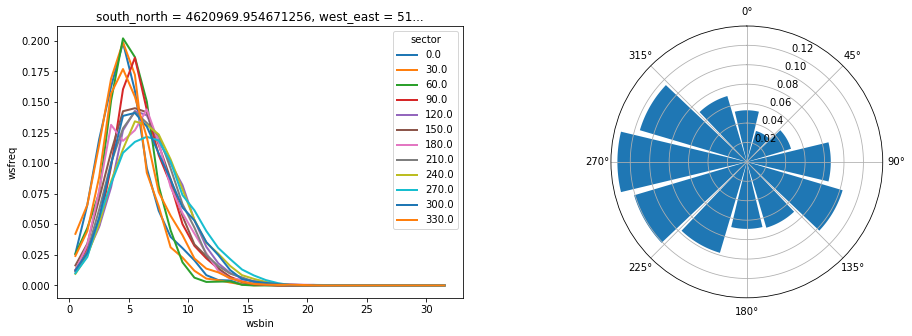

In [6]:
plot_bwc(bwc);

As expected the prevailing wind direction at the site is from west, thus the Atlantic ocean.



## Topography data

Now that we have loaded and inspected the wind climate, the next step is to the same with the terrain and roughness data. These data are used to calculate site effects used to generalize the observed wind climate ("going up" in WAsP lingo) and to downscale to nearby locations ("going down"). 

The site effects are:

 - Orographic speed-up (by sector)
 - Internal boundar layer speed-up (by sector)
 - Effective upstream surface roughness (by sector)
 
 > **__pywasp note__** WAsP includes site effects due to obstacles, but we will not consider those here

Convienietly the terrain and roughness data are provided as a single vector map `SerraSantaLuzia.map`. To load data we will use `pw.read_vectormap()`.

### Loading terrain and roughness data

To differentiate between the terrain and roughness parts of the vector map we need to tell `pw.read_vectormap()` which map type it is reading along with the EPSG code. To display loaded data we convert the vector data to raster data using method `to_rastermap()` and passing resolution as the argument (res = 100 m).

### Creating topography map

The elevation and roughness maps are the two components needed to make a `TopographyMap` object in `pywasp`, which is used to calculate the terrain effects. 

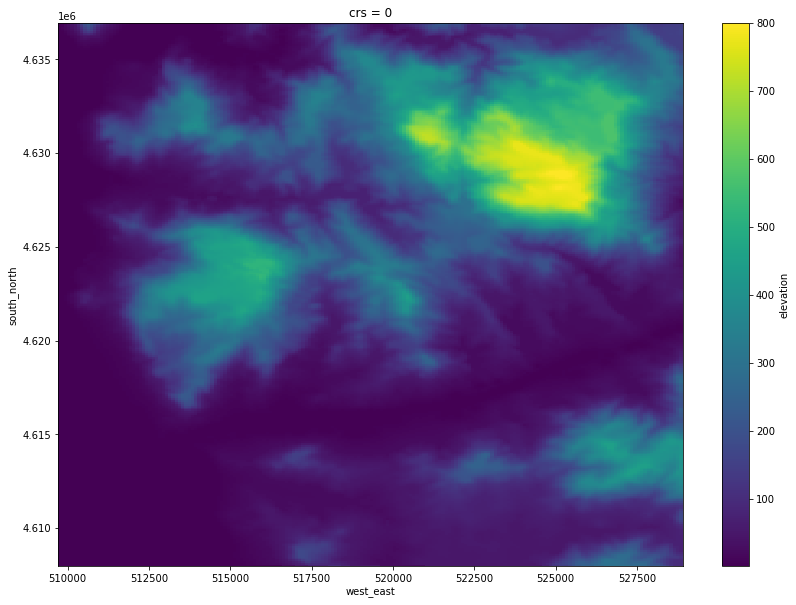

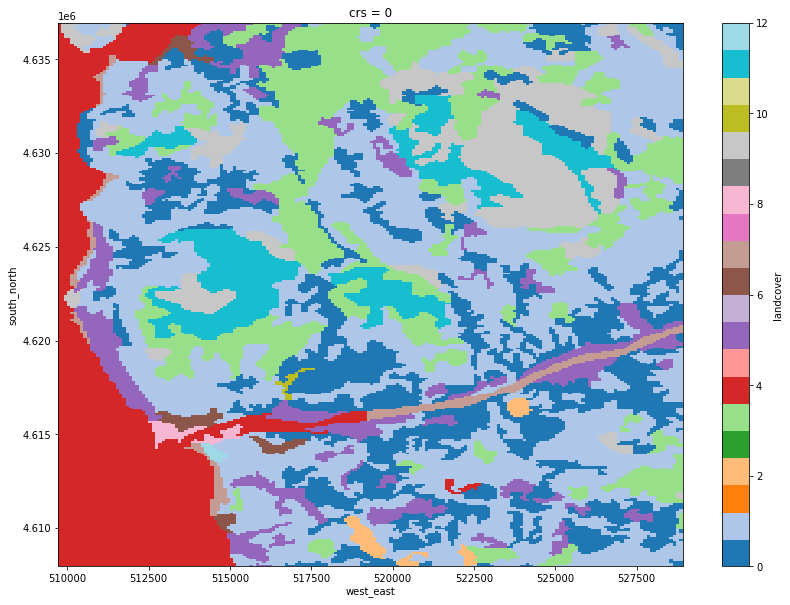

In [23]:
elev_map = pw.read_vectormap('data/SerraSantaLuzia.map', 32629, "elevation") 
pw.vectormap_to_rastermap(elev_map, res = 100).plot(figsize=(14, 10))

rgh_map, lut = pw.read_vectormap('data/SerraSantaLuzia.map', 32629, "roughness")
rgh_raster = pw.vectormap_to_rastermap(rgh_map, res = 100, lutable=lut)
rgh_raster.plot(cmap="tab20", figsize=(14, 10))

topo_map = pw.TopographyMap(elev_map, rgh_map, lut)

From the maps we can clearly observe the coast of the Atlantic ocean to the west as well the river Limia which flows into the ocean. Shown in red on the roughness map.

### Roughness Rose

Let's explore the roughness elements around the mast for each of 12 sectors. We can do this by using `get_rou_rose_pt` method of `topo_map`, and pass in the location of the mast and the number of sectors we would like to use. It requires a WAsP configuration object (`pywasp.wasp.Config`) that stores the parameters. We will simply use the default values.

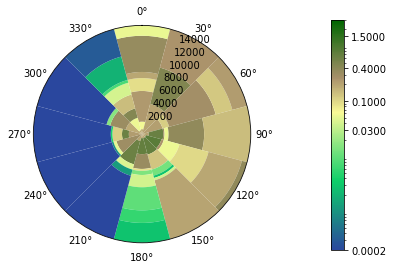

In [8]:
conf = pw.Config()
topo_map.get_elev_rose(loc_x, loc_y, 12, conf)

rou_rose = topo_map.get_rou_rose_pt(loc_x, loc_y, 12, conf,topo_map.get_elev_rose(loc_x, loc_y, 12, conf))
rou_rose.plot()

The presence of the Atlantic ocean is clearly visible to the west, and we see that the rose corresponds well to what we would expect from the roughness elements we saw in the map.

### Output Locations

Next up we will take a look at the site effects for the future turbine location. We need to tell `pywasp` what location we would like to calculate the site effects at. This is done by creating a `xarray.Dataset` with dimensions (`west_east`, `south_north`, and `height`) with coordinates values where we want to calculate the effects. Since this is a common need in PyWAsP, a convience function `create_dataset` has been created for this purpose.

We tell `pywasp` that the projection of `west_east`, `south_north` coordinates are in a UTM zone 29 by adding the attribute `epsg` giving it the integer number `32629`. 

In [9]:
output_locs =  pw.create_dataset( 
    np.array([514013.1]),
    np.array([4617763]),
    np.array([50]),
    32629
)
print(output_locs)

<xarray.Dataset>
Dimensions:      (point: 1)
Coordinates:
    height       (point) int64 50
    south_north  (point) int64 4617763
    west_east    (point) float64 5.14e+05
    crs          int64 0
Dimensions without coordinates: point
Data variables:
    output       (point) float64 0.0


### Site Effects Calculation

To get the site effects we will use the `get_site_effects` method from our `topo_map` object. 

`get_site_effects` expects the unique `west_east` and `south_north` values, the number of sectors, and the height above ground, and the configuration object.

> **__pywasp note__** depending on the number of locations, `get_site_effects` may take some time to complete

In [10]:
site_effects = topo_map.get_site_effects(output_locs, conf, 12)
print(site_effects)

<xarray.Dataset>
Dimensions:              (point: 1, sector: 12)
Coordinates:
  * point                (point) int64 0
    crs                  int64 0
    south_north          (point) int64 4617763
    west_east            (point) float64 5.14e+05
    height               (point) int64 50
  * sector               (sector) float64 0.0 30.0 60.0 ... 270.0 300.0 330.0
Data variables:
    z0meso               (sector, point) float32 0.18291926 ... 0.010897714
    slfmeso              (sector, point) float32 0.940817 1.0 ... 0.5341222
    displ                (sector, point) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    user_def_speedups    (sector, point) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    orographic_speedups  (sector, point) float32 1.1598146 1.14787 ... 1.4535618
    obstacle_speedups    (sector, point) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    roughness_speedups   (sector, point) float32 0.9235671 ... 0.8197055
    user_def_turnings    (sector, point) float32 0.0 0.0 0.0 0.0 .

The site effects dataset is made up of following variables:

 - `z0meso`: effective upstream roughness by sector
 - `slfmeso`: effective upstream sea-land-fraction by sector              
 - `displ`: displacement height by sector
 - `user_def_speedups`: user defined speed-ups (as factor)
 - `orographic_speedups`: speed-ups due to orography (as factor)
 - `obstacle_speedups`: obstacle induced speed-ups (as factor)
 - `roughness_speedups`: speed-ups due to roughness changes (as factor)
 - `user_def_turnings`: user defined wind turning (in degrees)
 - `orographic_turnings`: wind turning due to orography (in degrees)
 - `obstacle_turnings`: wind turning due to obstracels (in degrees)
 - `roughness_turnings`: wind turning due to roughness changes (in degrees)
 - `elev`: surface elevation 
 - `rix`: ruggedness index
 - `dirrix`: sector wise ruggedness index 


## The generalized wind climate calculation

Now it is time to actually generalize our observed wind climate and then downscale it to our chosen turbine location.  The generalized wind climate is a site-independent characterization of the wind climate for the entire Waspdale area.
Generalization involves calculating the wind speed for predefined surface roughnesses and heights above ground. So the first thing we need to do is chose these roughness and height classes. Typically, the wind climate contains up to 5 standard heights and 5 standard roughness classes.

In a generalized wind climate data set the wind observations have been 'cleaned' with respect to the site-specific conditions. The data sets are site-independent and the wind distributions have been referenced to five standard roughness classes and five standard height above ground level.

In [11]:
gen_roughnesses = np.array([0.001, 0.03, 0.1, 0.4, 1.5]) # 5 standard roughness classes
gen_heights = np.array([10.0, 50.0, 100.0, 150.0, 200.0])# 5 standard height classes

The generalization is done with the `generalize` function from `pywasp`'s `wasp` module. It takes the binned wind climate (`bwc`), our topographic map (`topo_map`), the roughness and height classes, and finally the configuration object (`conf`). 

In [12]:
gwc = pw.generalize(bwc, topo_map, conf, gen_roughnesses, gen_heights)
print(gwc)

<xarray.Dataset>
Dimensions:        (gen_height: 5, gen_roughness: 5, point: 1, sector: 12)
Coordinates:
    west_east      (point) float64 5.147e+05
    height         (point) float64 25.3
    crs            int64 0
    south_north    (point) float64 4.621e+06
  * sector         (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
  * gen_roughness  (gen_roughness) float64 0.001 0.03 0.1 0.4 1.5
  * gen_height     (gen_height) float64 10.0 50.0 100.0 150.0 200.0
Dimensions without coordinates: point
Data variables:
    A              (sector, gen_height, gen_roughness, point) float32 5.816133 ... 5.954249
    k              (sector, gen_height, gen_roughness, point) float32 1.7832031 ... 2.1855469
    wdfreq         (sector, gen_roughness, point) float32 0.07079139 ... 0.07612101
Attributes:
    header:   SerraSantaluzia


The generalized wind climate contains weibull parameters (`A` and `k`) for each location, sector, and height and roughness class.    

## Estimating wind power

### Setting up a turbine site

Now that the project contains a generalized wind climate (GWC) with site-independent wind climate data, we can apply those data to the proposed turbine site. `pywasp` will adjust the data for the situation found at the turbine site, and will produce a prediction of the wind climate for the site itself.

The `pywasp.wasp` module  provides two ways of doing this: `downscale` and `get_wasp_down`. The latter assumes site effects that have already been calculated, while the first one will start by calculating them. Since we have already calculated the site effects, we will use `get_wasp_down`. The function requires passing a `genwc_interp` method. Two choices are available: `'nearest'` and `'natural'`. This is important when several generalized wind climates are present and will tell `pywasp` how to interpolate them to the location. Since just one wind climate is present in this study, the same generalized wind climate will be used everywhere. 

In [38]:
pwc = pw.wasp.get_wasp_down(gwc, site_effects, conf, genwc_interp='nearest')

In [39]:
pwc['elev'] = site_effects['elev'] # adding ground level elevation for the turbine location
pwc = pw.add_met_fields(pwc) # calculating and adding additional met data
print(pwc)

<xarray.Dataset>
Dimensions:            (point: 1, sector: 12)
Coordinates:
  * point              (point) int64 0
  * sector             (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
    west_east          (point) float64 5.14e+05
    height             (point) int64 50
    crs                int64 0
    south_north        (point) int64 4617763
Data variables:
    A                  (sector, point) float32 5.842588 5.5358944 ... 7.024646
    k                  (sector, point) float32 2.1230469 2.4667969 ... 2.1035156
    wdfreq             (sector, point) float32 0.04836218 ... 0.07515231
    A_tot              (point) float64 8.916
    k_tot              (point) float64 2.232
    elev               (point) float32 240.0
    wspd_sector        (sector, point) float64 5.174 4.91 5.768 ... 8.11 6.222
    wspd               (point) float64 7.897
    air_dens           (point) float32 1.189708
    power_dens_sector  (sector, point) float64 148.6 112.2 179.6 ... 539.4 260.6
   

### Assigning the power curve and predicting AEP

In order to predict how much power will be produced by the turbine, `pywasp` needs to know the power production characteristics of the turbine. You provide this information to `pywasp` by importing `Bonus_1_MW_nice.wtg` using the `from_WAsP_wtg` method. Afterwards we pass the turbine information together with predicted wind climate to the `get_aep` method which calculates the anual energy production. 

In [42]:
wtg = pw.io.WindTurbine.from_WAsP_wtg('./data/Bonus_1_MW.wtg') # loading Bonus 1 MW wtg file to `pywasp` wtg object

In [49]:
A = pwc['A_tot'].values[0]
k = pwc['k_tot'].values[0]

aep = pw.get_aep(pwc, wtg)

print(f'AEP for the WAsPDale lonely turbine is {round(aep.values[0]/1000,2)} GWh')

AEP for the WAsPDale lonely turbine is 3.2 GWh


## Estimating wind farm production

We will now predict AEP for a wind farm consisting for 15 Bonus 1 MW wind turbines. The turbine positions are saved in a `turbine_positions.csv` file located in the `data` subfolder. To load the turbine coordinates we will use `pandas` method `read_csv` and then simply loop through the imported data and calculate AEP for each turbine.

In [50]:
wtg_locs = pd.read_csv('./data/turbine_positions.csv')
wtg_locs

,Turbine,Easting,Northing,Hub height
0,T1,513914,4622313,50
1,T2,514161,4622199,50
2,T3,514425,4622336,50
3,T4,513537,4622733,50
4,T5,513295,4622683,50
5,T6,513058,4622617,50
6,T7,515340,4621743,50
7,T8,515892,4622164,50
8,T9,515988,4622558,50
9,T10,514808,4622605,50


In [51]:
wf_aep = 0

for i, wtg_loc in wtg_locs.iterrows():
    output_locs =  pw.create_dataset( 
    np.array([wtg_loc['Easting']]),
    np.array([wtg_loc['Northing']]),
    np.array([wtg_loc['Hub height']]),
    32629)

    # Downscale to calculate total A and k
    pwc = pw.wasp.downscale(gwc, topo_map, output_locs, conf, genwc_interp='nearest')
    aep = pw.get_aep(pwc, wtg)

    wf_aep = wf_aep + aep.values[0]

In [52]:
print(f'Wind farm AEP is {round(wf_aep/1000,2)} GWh')

Wind farm AEP is 43.5 GWh


## Mapping the wind resources

To make a map of the wind resource over an area, we need to specify a grid where `pywasp` should calculated the wind resource. We will use the `pw.create_dataset` method to setup the grid. The grid will extend 20 km in *x* and *y* and will be positioned 50 m above ground level to match the Bonus turbine hub height. When plotting the wind resources we will highlight the barycenter of 15 wind turbines from the previous calculations.

In [20]:
# center of resource grid from WAsP help
loc_x = 515870.0 
loc_y = 4622470.0


half_ext = 20000.0 # half extent in x and y in m

output_locs = pw.create_dataset(
    np.linspace(loc_x-half_ext, loc_x+half_ext, 41).squeeze(),
    np.linspace(loc_y-half_ext, loc_y+half_ext, 41).squeeze(),
    np.array([50.0]),
    32629
)

In [21]:
pwc = pw.wasp.downscale(gwc, topo_map, output_locs, conf, genwc_interp='nearest')
print(pwc)

<xarray.Dataset>
Dimensions:            (height: 1, sector: 12, south_north: 41, west_east: 41)
Coordinates:
  * sector             (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
    crs                int64 0
  * height             (height) float64 50.0
  * south_north        (south_north) float64 4.602e+06 4.603e+06 ... 4.642e+06
  * west_east          (west_east) float64 4.959e+05 4.969e+05 ... 5.359e+05
Data variables:
    A                  (sector, height, south_north, west_east) float32 7.678571 ... 5.9071
    k                  (sector, height, south_north, west_east) float32 2.1464844 ... 2.1191406
    wdfreq             (sector, height, south_north, west_east) float32 0.07220063 ... 0.082290016
    A_tot              (height, south_north, west_east) float64 8.447 ... 7.09
    k_tot              (height, south_north, west_east) float64 2.365 ... 2.338
    wspd_sector        (sector, height, south_north, west_east) float64 6.8 ... 5.232
    wspd               (height

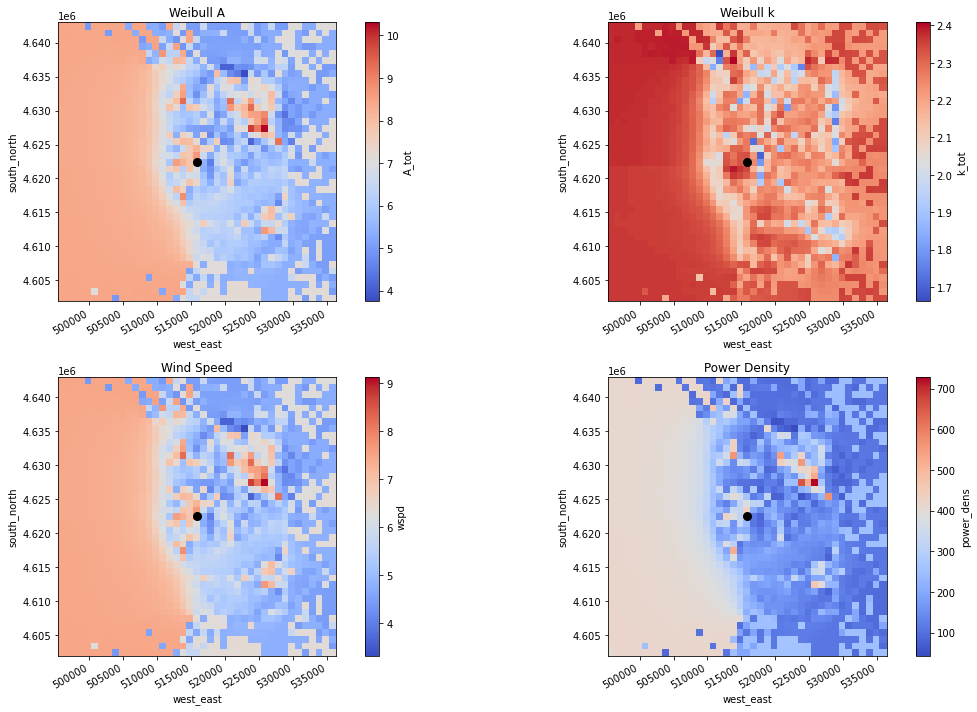

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
ax1, ax2, ax3, ax4 = axes.flat

variables = ['A_tot', 'k_tot', 'wspd', 'power_dens']

for var, ax in zip(variables, axes.flat):
    pwc[var].isel(height=0).plot(ax=ax, cmap='coolwarm')

    ax.plot(loc_x, loc_y, 'ko', ms=8, color='black')
    ax.set_aspect(1.0)    
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax1.set_title("Weibull A")
ax2.set_title("Weibull k")
ax3.set_title("Wind Speed")
ax4.set_title("Power Density");

fig.tight_layout()    